# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "baseline_cv_syn_data_mod"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
    'TS_73_6',
    'TS_86_3',
    'TS_99_9'
]

PROC_RAW = "proc/yolo11_cv_syn_data_baseline"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

# valデータはもともとのやつ使うのでパス分ける
PROC_VAL_RAW = "proc/yolo11_baseline_cv"

# PROC_VAL = f"../../{PROC_VAL_RAW}"
PROC_VAL_YAML = f"/workspace/CZII/{PROC_VAL_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(list_keyword):
    # Synthetic data用に変えてある
    train_paths = list_all_images(f"{PROC_YAML}/images")
    train_paths.sort()

    image_paths = list_all_images(f"{PROC_VAL_YAML}/images")
    image_paths.sort()

    val_paths   = []
    for keyword in list_keyword:
        # ファイル名をみて振り分け
        for p in image_paths:
            if contains_val_keyword(p, keyword):
                val_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
print("="*100)
print(f"Processing {LIST_CV}...")
extract_train_val_paths(LIST_CV)

# Load a pretrained model
model = YOLO("yolo11l.pt")  # load a pretrained model (recommended for training)

# Train the model
_ = model.train(
    data=f"{PROC}/cv_conf.yaml",
    name=EXP_NAME,
    epochs=25,
    warmup_epochs=3,
    optimizer='AdamW',
    cos_lr=True,
    lr0=5e-5,
    lrf=0.01,
    imgsz=640,
    device="0",
    weight_decay=0.01,
    batch=16,
    scale=0,
    flipud=0.5,
    fliplr=0.5,
    degrees=90,
    shear=5,
    mixup=0.2,
    copy_paste=0.25,
    seed=8620, # (｡•◡•｡)
)

Processing ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']...
Found 5400 train images.
Found 1288 val images.
Train list saved to ../../proc/yolo11_cv_syn_data_baseline/train.txt
Val list saved to ../../proc/yolo11_cv_syn_data_baseline/val.txt
New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)


engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=../../proc/yolo11_cv_syn_data_baseline/cv_conf.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=baseline_cv_syn_data_mod, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchsc

train: Scanning /workspace/CZII/proc/yolo11_cv_syn_data_baseline/labels.cache... 5400 images, 365 backgrounds, 0 corrupt: 100%|██████████| 5400/5400 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1288 images, 302 backgrounds, 0 corrupt: 100%|██████████| 1288/1288 [00:06<00:00, 192.78it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_mod/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(b1636c33cb484000b76c2a58dc93c035) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_mod
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.3G      1.405       1.11      1.119        476        640: 100%|██████████| 338/338 [02:28<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


                   all       1288      24799      0.388      0.373       0.33      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.5G      1.164     0.7768          1        403        640: 100%|██████████| 338/338 [02:22<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.71it/s]


                   all       1288      24799      0.413      0.454      0.393      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.084     0.7166     0.9713        421        640: 100%|██████████| 338/338 [02:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.58it/s]


                   all       1288      24799      0.426      0.492      0.378      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.4G      1.042     0.6785     0.9568        420        640: 100%|██████████| 338/338 [02:19<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


                   all       1288      24799       0.43      0.489      0.399      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.3G      1.022     0.6598     0.9486        323        640: 100%|██████████| 338/338 [02:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                   all       1288      24799      0.442      0.514      0.406      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.4G     0.9901     0.6431     0.9384        386        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                   all       1288      24799       0.44      0.478      0.385      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G     0.9786     0.6298     0.9347        456        640: 100%|██████████| 338/338 [02:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


                   all       1288      24799      0.442      0.481       0.39      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.4G     0.9624      0.618     0.9288        429        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                   all       1288      24799      0.441      0.478       0.39      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.4G     0.9571     0.6078     0.9268        442        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


                   all       1288      24799      0.416      0.476      0.384      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.6G     0.9398     0.5997     0.9218        349        640: 100%|██████████| 338/338 [02:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                   all       1288      24799      0.443      0.479      0.396      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.4G     0.9334     0.5885     0.9193        461        640: 100%|██████████| 338/338 [02:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


                   all       1288      24799      0.457      0.444      0.388      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.5G     0.9213     0.5839     0.9159        479        640: 100%|██████████| 338/338 [02:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                   all       1288      24799      0.449      0.458      0.384      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.4G     0.9093      0.575     0.9126        399        640: 100%|██████████| 338/338 [02:18<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


                   all       1288      24799      0.447      0.453      0.392       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.3G      0.888     0.5652     0.9062        464        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


                   all       1288      24799      0.441      0.437      0.396      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.4G     0.8676     0.5541     0.9015        494        640: 100%|██████████| 338/338 [02:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                   all       1288      24799      0.456      0.486       0.41      0.263
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.1G     0.7673     0.4672     0.8657        334        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                   all       1288      24799       0.46      0.473      0.406      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25        11G     0.7373     0.4537     0.8583        355        640: 100%|██████████| 338/338 [02:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


                   all       1288      24799      0.457      0.491      0.411      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.1G     0.7276     0.4491     0.8565        288        640: 100%|██████████| 338/338 [02:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.68it/s]


                   all       1288      24799      0.441      0.489      0.404      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.1G      0.711     0.4427     0.8523        326        640: 100%|██████████| 338/338 [02:15<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.73it/s]


                   all       1288      24799      0.459      0.476      0.405      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25        11G     0.7068       0.44      0.852        278        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


                   all       1288      24799      0.471       0.48      0.411      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.1G     0.6985     0.4352     0.8492        288        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                   all       1288      24799      0.465      0.467      0.406      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.1G      0.693     0.4322     0.8486        254        640: 100%|██████████| 338/338 [02:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                   all       1288      24799      0.468      0.475      0.408      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.1G     0.6876     0.4313     0.8474        223        640: 100%|██████████| 338/338 [02:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                   all       1288      24799      0.461       0.47      0.402      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25        11G     0.6884     0.4296     0.8471        435        640: 100%|██████████| 338/338 [02:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                   all       1288      24799      0.462      0.471      0.404      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.1G     0.6844      0.429     0.8466        255        640: 100%|██████████| 338/338 [02:14<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                   all       1288      24799       0.46      0.475      0.404       0.27

25 epochs completed in 1.076 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_mod/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_mod/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_mod/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▍         | 2/41 [00:00<00:17,  2.18it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                   all       1288      24799      0.438      0.501      0.396       0.27
          apo-ferritin        822       4116      0.524       0.46      0.398      0.214
    beta-galactosidase        661       1900      0.104      0.334     0.0763     0.0394
              ribosome        867       9591      0.507      0.822       0.65      0.432
         thyroglobulin        934       6262      0.172      0.267      0.109     0.0658
   virus-like-particle        647       2930      0.885      0.626      0.744      0.597
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_mod
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [9]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]

list_results = []
df_result = pd.DataFrame(columns=columns)
df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")

list_results = [
    df.iloc[-1]["metrics/precision(B)"],
    df.iloc[-1]["metrics/recall(B)"],
    df.iloc[-1]["metrics/mAP50(B)"],
    df.iloc[-1]["metrics/mAP50-95(B)"],
]
df_result.loc[f"val"] = list_results
# df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
"val_['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']",0.46,0.475,0.404,0.27


In [10]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
)

display(HTML(html_content))

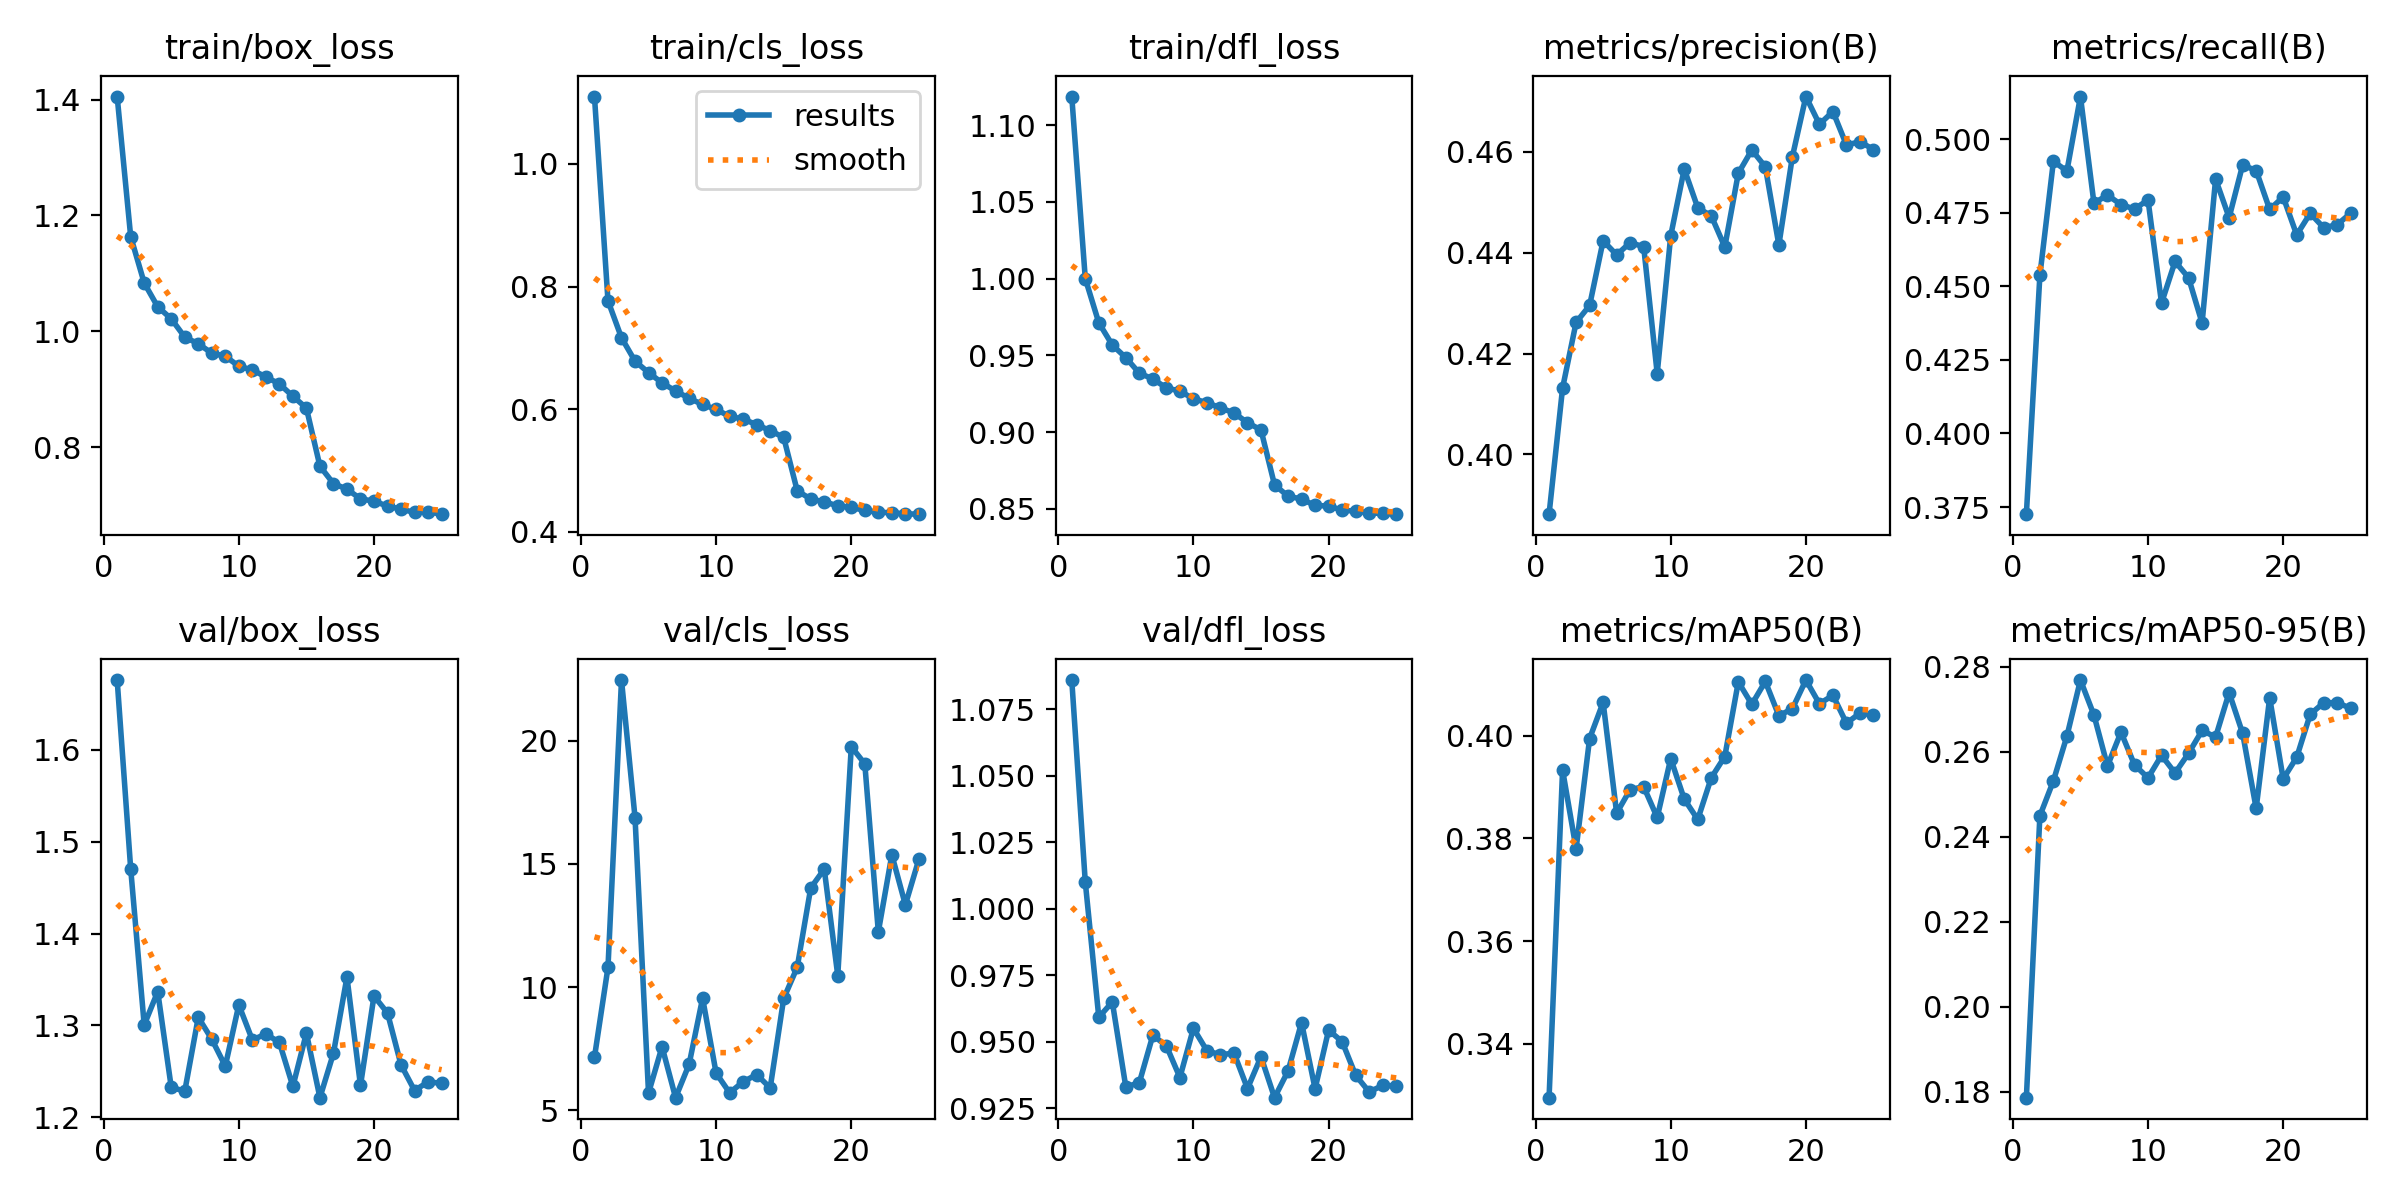

In [11]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)